In [417]:
import numpy as np
import pandas as pd
import math
import operator
import matplotlib.pyplot as plt
import pprint

In [449]:
def get_test_train(location):
    location = '~/Documents/SMAI/Assignment2/' + location
    dataframe = pd.read_csv(location,header = None)
    train  = dataframe[:int(0.8*len(dataframe))]
    test = dataframe[int(0.8*len(dataframe)):]
    return test,train

In [442]:
'''
USED IN KNN
'''
def minkowski_predict(test_row,train_row,power,target):
    dist = 0
    for attribute in range(0,len(test_row)):
        if attribute != target:
            dist+=(pow(abs(test_row[attribute] - train_row[attribute]),power))
    return dist 

In [443]:
'''
USED IN KNN
'''
def getsecond(item):
    return item[1]


def KNN(test,train,K,dist_measure,target):
    unique_values = np.unique(train.values[:,target])
    maxval = -1
    winner = None
    class_dict = {}
    for classVal in unique_values:
        class_dict[classVal] = 0
  
    if dist_measure == 'euclid':
        power = 2
    elif dist_measure == 'cheby':
        power = 1
    predicted = []
    for test_row in test.values:
        #print(test_row)
        knn = []
        maxval = -1
        winner = None
        for train_row in train.values:
            #print(train_row)
            #print(test_row)
            y = minkowski_predict(test_row,train_row,power,target)
            #print(y)
            knn.append((train_row[target],y))
        knn.sort(key = getsecond)
        
        #print(knn)
        for i in range(0,K):
            class_dict[knn[i][0]]+=1
            #if class_dict[knn[i][0]] > maxval:
            #    winner = knn[i][0]
            #    maxval = class_dict[knn[i][0]]
        winner = max(class_dict.items(),key=operator.itemgetter(1))[0]    
        predicted.append(winner)
        #print(class_dict)
        for classVal in unique_values:
            class_dict[classVal] = 0
    return predicted        

In [485]:
'''
USED IN NAIVE BAYES
'''
def NaivePredict(NaiveModel,test,train,target,catcolumns):
    size = train.shape[0]  
    class_count = {}
    unique_classes = np.unique(train.values[:,target])
    for classes in unique_classes:
        class_count[classes] = 0 
        
    for i in train.values[:,target]:
        class_count[i]+=1/size
    result= 1
    column_pos=1
    largest=-1
    class_lab = None
    predicted_y = []
    #print(train)
    #print(test)
    for row in test.values:
        #print(row)
        for key in NaiveModel:
            while column_pos < row.shape[0]:
                if column_pos!=target:
                    if column_pos in catcolumns:
                        result *= NaiveModel[key][column_pos][row[column_pos]] 
                    else:
                        #print(key,column_pos,NaiveModel[key][column_pos])
                        mean = NaiveModel[key][column_pos]['mean']
                        var = NaiveModel[key][column_pos]['var']
                        distribution = 1/(np.sqrt(2*np.pi*var)) * np.exp((-(row[column_pos]-mean)**2)/(2*var))
                        result*=distribution
                else:
                    column_pos+=1 
                    continue
                column_pos+=1    
            
            result*=class_count[key]
            column_pos = 1
            if result > largest:
                largest = result
                class_lab = key
            result=1    
        
        predicted_y.append(class_lab)
        largest=-1
        class_lab=None
    #print(predicted_y)
    a,p,r,f = BinaryMeasure(predicted_y,test,target)
    print(a,p,r,f)
                        

In [486]:
'''
USED IN NAIVE BAYES
'''

def NaiveBayes(train,target,catcolumns):
    #get a count of classes in target variable
    unique_classes = np.unique(train.values[:,target])
    size = train.shape[0]
    class_dict = {}
  
    for classes in unique_classes:
        class_dict[classes] = {}    #For probability
        
    column_pos = 1  
    noofcolumns = train.values.shape[1] 
    while column_pos < noofcolumns:
        attribute = train.values[:,column_pos]
        for key in class_dict:
            class_dict[key][column_pos] = {}
            filtered_mat = train.values[(train.values[:,target] == key),:]
            key_size = filtered_mat.shape[0]
            if column_pos in catcolumns:
                unique_category = np.unique(attribute)
                for category in unique_category:
                    class_dict[key][column_pos][category] = 0
                    filtered_mat = (train.values[:,column_pos] == category) & (train.values[:,target] == key)
                    filtered_mat = train.values[filtered_mat,:]
                    class_dict[key][column_pos][category] = filtered_mat.shape[0]/key_size
            elif column_pos!=target:
                mean = filtered_mat[:,column_pos].mean(axis=0)
                var = filtered_mat[:,column_pos].var(axis=0)
                class_dict[key][column_pos]['mean'] = mean
                class_dict[key][column_pos]['var'] = var
        column_pos+=1
    return class_dict    
    #pprint.pprint(class_dict)        
                    
                

In [446]:
def BinaryMeasure(predicted_y,test,target):
    j = 0
    TN=0
    TP=0
    FN=0
    FP=0
    for i in predicted_y:
        if i==0 and i == (test.values)[j][target]:
            TN+=1
        elif i==0 and i!= (test.values)[j][target]:
            FN+=1
        elif i==1 and i == (test.values)[j][target]:
            TP+=1
        elif i==1 and i!= (test.values)[j][target]:
            FP+=1
        j+=1
        
    accuracy =  (TP+TN)/(TP+TN+FP+FN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    fscore = 2/((1/precision)+(1/recall))
    return accuracy,precision,recall,fscore

In [447]:
def MultipleMeasure(predicted_y,test,train,target):
    j=0
    unique_classes = np.unique(train.values[:,target])
    accuracy = 0
    precision = 0
    recall = 0
    fscore = 0

    class_dict = {}
    for lclass in unique_classes:
        class_dict[lclass] = 0
   
    for i in (test.values)[:,target]:
        class_dict[i]+=1
        j+=1
    j=0
    
    size = test.shape[0]
    
    for lclass in unique_classes:
        TN=0
        TP=0
        FN=0
        FP=0
        freq = class_dict[lclass]
        for i in predicted_y:
            if lclass == (test.values)[j][target] and i==lclass: 
                TP+=1
            elif lclass!= (test.values)[j][target] and i==lclass:
                FP+=1
            elif lclass!= (test.values)[j][target] and i!=lclass:
                TN+=1
            elif lclass == (test.values)[j][target] and i!=lclass:
                FN+=1
            j+=1
        j=0    

        accuracy +=  (freq/size)*((TP+TN)/(TP+TN+FP+FN))
        precision += (freq/size)*((TP)/(TP+FP))
        recall += (freq/size)*((TP)/(TP+FN))
        fscore += (freq/size)*(2/((1/precision)+(1/recall)))
    return accuracy,precision,recall,fscore

## Question - 1
### A. Datasets -- Robot1 and Robot2

### 1. Implement a KNN classifier for each of the datasets. Report precision, recall, f1 score and accuracy. Compare your result with in-built(scikit-learn) KNN function to check correctness of your algorithm.

In [450]:
#Robot1
location = 'RobotDataset/Robot1'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
K = 7
target = 0
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
print("Robot1")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)

print("\n")

#Robot2
location = 'RobotDataset/Robot2'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
K = 7
target = 0
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
print("Robot2")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)

print("\n")

#Iris
location = 'Iris/Iris.csv'
test,train = get_test_train(location)
K = 7
target = 4
predicted_y = KNN(test,train,K,'euclid',target)
accuracy,precision,recall,fscore = MultipleMeasure(predicted_y,test,train,target)
print("Iris")
print("===================================")
print("Accuracy = ",accuracy)
print("Precision = ",precision)
print("Recall = ",recall)
print("fscore = ",fscore)


Robot1
Accuracy =  0.84
Precision =  1.0
Recall =  0.8095238095238095
fscore =  0.8947368421052632


Robot2
Accuracy =  0.92
Precision =  1.0
Recall =  0.8181818181818182
fscore =  0.8999999999999999


Iris
Accuracy =  0.9780521262002742
Precision =  0.9682539682539681
Recall =  0.9629629629629629
fscore =  0.6615986914139392


### 2. Use different distance measures as applicable. Plot graph to report accuracy with change in value of K. Also suggest possible reason for better performance.

In [451]:
def gen_KNN_plot(test,train,target,binary):
    distanceMeasures = ['euclid','cheby'] 
    accuracy_array1 = []
    accuracy_array2 = []
    for dist_measure in distanceMeasures:
        K = 1
        K_array = []
        accuracy_array2 = []
        while K<= math.sqrt(len(train)):
            predicted_y = KNN(test,train,K,dist_measure,target)
            if binary == 1:
                accuracy,precision,recall,fscore = BinaryMeasure(predicted_y,test,target)
            elif binary == 0:
                accuracy,precision,recall,fscore = MultipleMeasure(predicted_y,test,train,target)
            K_array.append(K)
            accuracy_array2.append(accuracy)
            K+=2
        if dist_measure == 'euclid':    
            accuracy_array1 = accuracy_array2.copy()    
    plt.plot(K_array,accuracy_array1,c='b',label = 'euclid')
    plt.plot(K_array,accuracy_array2,c='r',label = 'chebychev')
    plt.legend()
    plt.show()


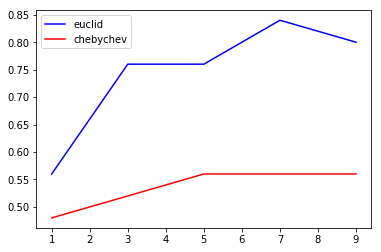

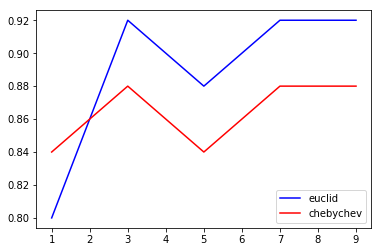

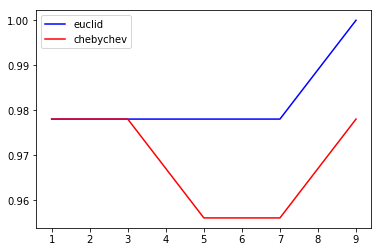

In [427]:
location = 'RobotDataset/Robot1'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
target=0
binary = 1
gen_KNN_plot(test,train,target,binary)

location = 'RobotDataset/Robot2'
test,train = get_test_train(location)
test = pd.DataFrame(np.delete(test.values,7,1))
train = pd.DataFrame(np.delete(train.values,7,1))
target=0
binary=1
gen_KNN_plot(test,train,target,binary)

location = 'Iris/Iris.csv'
test,train = get_test_train(location)
target = 4
binary=0
gen_KNN_plot(test,train,target,binary)

## Question - 2
### A bank is implementing a system to identify potential customers who have higher probablity of availing loans to increase its profit. Implement Naive Bayes classifier on this dataset to help bank achieve its goal. Report your observations and accuracy of the model.

In [487]:
location = 'LoanDataset/data.csv'
test,train = get_test_train(location)
catcolumns = [7,10,11,12,13]
target = 9
NaiveModel = NaiveBayes(train,target,catcolumns)
NaivePredict(NaiveModel,test,train,target,catcolumns)

0.9155555555555556 0.5196078431372549 0.6625 0.5824175824175825
